In [ ]:
!pip install transformers
!pip install gensim
!pip install --upgrade gensim
!pip uninstall numpy
!pip install numpy==1.24.4



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Found existing installation: numpy 1.2

In [ ]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Binarizer

from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.parsing.preprocessing import (STOPWORDS, strip_tags,
strip_numeric, strip_punctuation, strip_multiple_whitespaces,
remove_stopwords, strip_short, stem_text)
import nltk
import pickle
import pandas as pd
import torch
import re
import string


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# read in csv file
path = '/content/drive/MyDrive/Colab Notebooks/NLP/Verträge_mit_Content.csv'
df = pd.read_csv(path)

Mounted at /content/drive


In [ ]:
print(df.iloc[13,6])

§ 1 Definitionen Allgemeine Bedingungen – die vorliegenden Allgemeinen Geschäftsbedingungen für die Comarch Service-Produkte. Applikation – die sogenannte Zugangssoftware, deren Einsatz die Voraussetzung oder ggf. die Alternative für die Nutzung des Comarch Service-Produktes ist und die auf den Arbeitsplätzen der Nutzer installiert sein muss. Arbeitsergebnisse – die vom Kunden in die Datenbanken des Comarch Service-Produktes eingegebenen Daten und Dateien sowie die vom Kunden mittels des Comarch Service-Produktes erstellte Ergebnisse (Daten, Dateien), die auf den von Comarch zur Verfügung gestellten Servern vom Kunden gespeichert werden. Bestellung – ein Angebot des Bestellers an Comarch in elektronischer Form bezüglich der Nutzung von Comarch Service-Produkten gemäß den Bestimmungen dieser Allgemeinen Bedingungen. Comarch – Comarch AG. Comarch Service Angebot – Comarch Service-Produkte, die dem Kunden unter den verschiedenen Webauftritten von Comarch wie z.B. https://www.erpxt.de oder

Since we want to classify paragraphs rather than whole Contracts we need to split the contracts in smaller chunks.

In [ ]:
def extract_paragraphs_and_sections(row):
    import re

    text = row['content']
    contract_id = row['contract']
    lines = text.splitlines()
    paragraphs = []
    current_para_lines = []
    current_para_number = None
    current_para_match = None

    # 1. extract paragraphs

    for line in lines:
        line = line.strip()
        if not line:
            continue

        match_main = re.match(r'(§\s*\d+|^\d+\.)\s+', line)

        if match_main:
            if current_para_lines:
                paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))
            current_para_number = match_main.group(1).strip().lstrip('§').rstrip('.')  # e.g. "14"
            current_para_match = match_main.group(0).strip()
            current_para_lines = [line]
        elif current_para_lines:
            current_para_lines.append(line)

    if current_para_lines:
        paragraphs.append((current_para_number, ' '.join(current_para_lines), current_para_match))

    rows = []
    seen_sections = set()  # (contract_id, para_num, section_id)

    for para_num, para_text, para_match in paragraphs:
        print(seen_sections)
        print(para_text)
        matches = list(re.finditer(rf'(?:(?<=\s)|(?<=^))({para_num}\.\d+)(?:\.|\b)(?=\s)', para_text))
        print(matches)

        if not matches:
            rows.append({
                'contract': contract_id,
                'paragraph': para_match,
                'paragraph_content': para_text.strip(),
                'section': "no sections use paragraph",
                'section_content': para_text.strip()
            })
            continue

        positions = []
        for match in matches:
            section_id = match.group(1)
            start = match.start()
            print(f'match: {match} section_id: {section_id}, start_{start}')

            # Skip if this section was already processed for this contract and paragraph
            section_key = (contract_id, para_num, section_id)
            if section_key in seen_sections:
                print(f'match: {match} exisitert beretis überspringen...')
                continue

            seen_sections.add(section_key)
            positions.append((start, section_id))
            print('postion added')

        # Add end position
        positions.append((len(para_text), None))
        positions = sorted(positions)
        print(f'positions = {positions}')
        print('###########')

        for i in range(len(positions) - 1):
            start_pos = positions[i][0]
            end_pos = positions[i + 1][0]
            section_id = positions[i][1]
            section_text = para_text[start_pos:end_pos].strip()

            rows.append({
                'contract': contract_id,
                'paragraph': para_match,
                'paragraph_content': para_text.strip(),
                'section': section_id,
                'section_content': section_text
            })

    return rows






def clean_paragraph_text(text):
    # 1. remove paragraph marker z. B. '§ 1' oder '1.'
    text = re.sub(r'^(§\s*\d+|\d+\.)\s+', '', text)
    text = re.sub(r'(?<!\d)(\d+\.\d+)(?=\s)', '',text)

    # 2. remove punctation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. remove double whitespaces
    text = re.sub(r'\s+', ' ', text)

    # 4. remove whitespace beginning and end
    return text.strip()




In [ ]:
# filter df to relevant contracts
df_relevant = df[(df['Kategorie'] == "kleinere SaaS-Anbieter (Hauptgruppe)") & (df['Sprache'] == "DE") & (df['Quelle/Organisation'] != "Comarch ERP XT"	)]
df_relevant = df_relevant.iloc[:,[0,6]]
df_relevant.columns = ['contract', 'content']
df_relevant.head()

,contract,content
10,10,Mit der Inanspruchnahme unserer Dienstleistung...
11,11,Dräger Software as a Service - Nutzungsbedingu...
12,12,1. Einleitung 1.1 Geschäftspartner Dieser Vert...
14,14,Vertragsbedingungen SaaS-Vertrag\nder TA Trium...
16,16,Allgemeine Geschäfts- Und Nutzungsbedingungen\...


In [ ]:
# apply prargrah and section extractor
df_exploded = df_relevant.apply(extract_paragraphs_and_sections, axis=1)

print(df_exploded.head())
# flatten the lists to a df
from itertools import chain
flattened_rows = list(chain.from_iterable(df_exploded))

# build df
df_structured = pd.DataFrame(flattened_rows)

set()
1. Vertragsgegenstand 1.1 Diese Vertragsbedingungen gelten für die Nutzung der Software des Anbieters gemäß der aktuellen Produktbeschreibung und dem Auftragsblatt als Software as a Service („SaaS“) bzw. Cloud-Angebot. 1.2 Die Software wird vom Anbieter als SaaS- bzw. Cloud-Lösung betrieben. Dem Kunden wird ermöglicht, die auf den Servern des Anbieters bzw. eines vom Anbieter beauftragten Dienstleisters gespeicherte und ablaufende Software über eine Internetverbindung während der Laufzeit dieses Vertrags für eigene Zwecke zu nutzen und seine Daten mit ihrer Hilfe zu speichern und zu verarbeiten. 1.3 Diese Vertragsbedingungen gelten ausschließlich. Vertragsbedingungen des Kunden finden keine Anwendung. Gegenbestätigungen des Kunden unter Hinweis auf seine eigenen Geschäftsbedingungen wird ausdrücklich widersprochen.
[<re.Match object; span=(22, 25), match='1.1'>, <re.Match object; span=(219, 222), match='1.2'>, <re.Match object; span=(603, 606), match='1.3'>]
match: <re.Match obje

In [ ]:
def extract_title_fixed(group):
    import re
    paragraph_text = group['paragraph_content'].iloc[0]
    section_texts = group['section_content'].tolist()

    # No Sections (single paragraph)
    if len(section_texts) == 1 and group['section'].iloc[0] == "no sections use paragraph":
        # find sentence end
        match = re.search(r'\b(Der|Die|Das|Es|Ein|Eine)\s+[A-ZÄÖÜ][a-zäöü]+\b', paragraph_text)
        if match:
            title = paragraph_text[:match.start()].strip()
        else:
            # Fallback: to first verb or 8 words
            title = ' '.join(paragraph_text.split()[:8])
        return pd.Series([title] * len(group), index=group.index)

    # secction split
    for section in section_texts:
        paragraph_text = paragraph_text.replace(section, '')
    title = paragraph_text.strip()
    return pd.Series([title] * len(group), index=group.index)


df_structured['paragraph_title'] = df_structured.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)
# select cols

df_structured = df_structured[
    ['contract', 'paragraph', 'paragraph_title', 'paragraph_content', 'section', 'section_content']
]

# remove title
df_structured['paragraph_title'] = df_structured.apply(
    lambda row: row['paragraph_title'].replace(row['paragraph'], '').strip() if pd.notnull(row['paragraph_title']) else '',
    axis=1
)


df_structured["clean_paragraph_content"] = df_structured["paragraph_content"].apply(clean_paragraph_text)
df_structured["clean_section_content"] = df_structured["section_content"].apply(clean_paragraph_text)


df_structured["clean_paragraph_content"] = df_structured.apply(
    lambda row: row["clean_paragraph_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["clean_paragraph_content"]) else '',
    axis=1
)

df_structured["clean_section_content"] = df_structured.apply(
    lambda row: row["clean_section_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["clean_section_content"]) else '',
    axis=1
)

print(df_structured.shape)

<ipython-input-10-88ed70be2e77>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_structured['paragraph_title'] = df_structured.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)


(441, 8)


In [ ]:
# export first excel
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP/test.xlsx'
df_structured.to_excel(file_path, index=False)



In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
from transformers import BertTokenizer
bert_uncased = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
df_structured["paragraph_content_stemm"]=df_structured['clean_paragraph_content'].apply(
    lambda text: stem_text(text)
)
df_structured["paragraph_content_lemma"]=df_structured['clean_paragraph_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df_structured["paragraph_content_token"]=df_structured['clean_paragraph_content'].apply(
    lambda text: bert_uncased.tokenize(text)
)

In [ ]:
df_structured["section_content_stemm"]=df_structured['clean_section_content'].apply(
    lambda text: stem_text(text)
)
df_structured["paragraph_section_lemma"]=df_structured['clean_section_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)
df_structured["paragraph_section_token"]=df_structured['clean_section_content'].apply(
    lambda text: bert_uncased.tokenize(text)
)

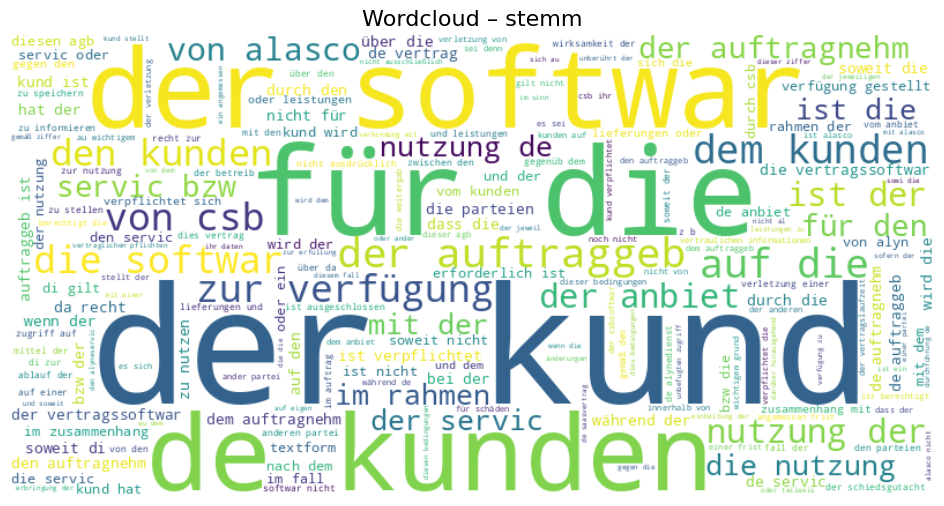

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
topic_text = " ".join(df_structured["paragraph_content_stemm"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Wordcloud – stemm", fontsize=16)
plt.show()

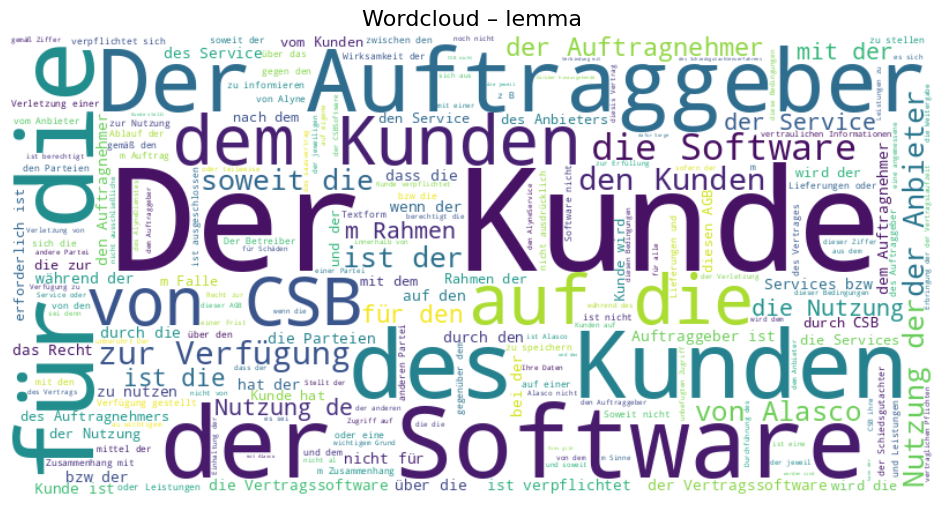

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
topic_text = " ".join(df_structured["paragraph_content_lemma"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Wordcloud – lemma", fontsize=16)
plt.show()

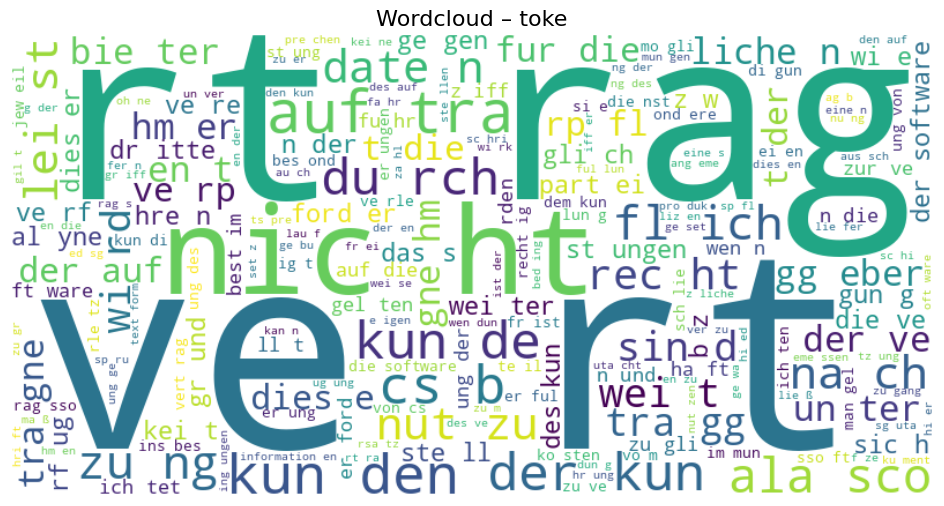

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
topic_text = " ".join(
    word for tokens in df_structured["paragraph_content_token"].dropna() for word in tokens
)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"Wordcloud – toke", fontsize=16)
plt.show()

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP/clean.xlsx'
df_structured.to_excel(file_path, index=False)
